In [17]:
import urllib.request
import tensorflow as tf
import os
from tensorflow.python.saved_model import signature_def_utils
import shutil
# If models esists, remove them for saving new models. 
if os.path.exists("./multi"):
    shutil.rmtree("./multi")

download_file = "ssd_mobilenet_v1_coco_2018_01_28.tar.gz"
if not os.path.exists(download_file):
    url ="http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_2018_01_28.tar.gz"
    urllib.request.urlretrieve(url, download_file)

!tar xvzf $download_file

# Specify version 1
export_dir = 'multi/model1/0/'
graph_pb = 'ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb'
        
builder = tf.saved_model.builder.SavedModelBuilder(export_dir)

with tf.gfile.GFile(graph_pb, "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    
sigs = {}

with tf.Session(graph=tf.Graph()) as sess:
    # name="" is important to ensure we don't get spurious prefixing
    tf.import_graph_def(graph_def, name="")
    g = tf.get_default_graph()
    input_image = g.get_tensor_by_name("image_tensor:0")
    detection_boxes = g.get_tensor_by_name('detection_boxes:0')
    detection_scores = g.get_tensor_by_name('detection_scores:0')
    detection_classes = g.get_tensor_by_name('detection_classes:0')
    num_detections = g.get_tensor_by_name('num_detections:0')
    
    sigs[signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY] = \
        tf.saved_model.signature_def_utils.predict_signature_def(
            {"input": input_image},
            {"boxes": detection_boxes,
             "scores": detection_scores,
             "classes": detection_classes,
             "n_detect": num_detections} )

    builder.add_meta_graph_and_variables(sess,
                                         [tag_constants.SERVING],
                                         signature_def_map=sigs)

    builder.save()

ssd_mobilenet_v1_coco_2018_01_28/
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.index
ssd_mobilenet_v1_coco_2018_01_28/checkpoint
ssd_mobilenet_v1_coco_2018_01_28/pipeline.config
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.data-00000-of-00001
ssd_mobilenet_v1_coco_2018_01_28/model.ckpt.meta
ssd_mobilenet_v1_coco_2018_01_28/saved_model/
ssd_mobilenet_v1_coco_2018_01_28/saved_model/saved_model.pb
ssd_mobilenet_v1_coco_2018_01_28/saved_model/variables/
ssd_mobilenet_v1_coco_2018_01_28/frozen_inference_graph.pb
INFO:tensorflow:Restoring parameters from ssd_mobilenet_v1_coco_2018_01_28/model.ckpt
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: multi/model1/0/saved_model.pb


In [133]:
import urllib.request
import os

download_file = "resnet_v2_fp32_savedmodel_NHWC.tar.gz"
model2_dir = "multi/model2/0/"
if not os.path.exists(download_file):
    url ="http://download.tensorflow.org/models/official/20181001_resnet/savedmodels/resnet_v2_fp32_savedmodel_NHWC.tar.gz"
    urllib.request.urlretrieve(url, download_file)

os.makedirs(model2_dir, exist_ok=True)
os.makedirs(model2_dir+'variables', exist_ok=True)
    
!tar xvzf $download_file
!mv resnet_v2_fp32_savedmodel_NHWC/1538687283/* $model2_dir

./resnet_v2_fp32_savedmodel_NHWC/
./resnet_v2_fp32_savedmodel_NHWC/1538687283/
./resnet_v2_fp32_savedmodel_NHWC/1538687283/variables/
./resnet_v2_fp32_savedmodel_NHWC/1538687283/variables/variables.index
./resnet_v2_fp32_savedmodel_NHWC/1538687283/variables/variables.data-00000-of-00001
./resnet_v2_fp32_savedmodel_NHWC/1538687283/saved_model.pb


In [134]:
!tar -czvf multi.tar.gz ./multi

import sagemaker
from sagemaker import get_execution_role
sagemaker_session = sagemaker.Session()
models = sagemaker_session.upload_data(path='./multi.tar.gz', key_prefix='pretrained_model/multiple_models/')

./multi/
./multi/model1/
./multi/model1/0/
./multi/model1/0/saved_model.pb
./multi/model1/0/variables/
./multi/model2/
./multi/model2/0/
./multi/model2/0/saved_model.pb
./multi/model2/0/variables/
./multi/model2/0/variables/variables.index
./multi/model2/0/variables/variables.data-00000-of-00001


In [136]:
from sagemaker.tensorflow.serving import Model, Predictor


role = get_execution_role()

# For multi-model endpoints, you should set the default model name in
# an environment variable. If it isn't set, the endpoint will work,
# but the model it will select as default is unpredictable.
env = {
  'SAGEMAKER_TFS_DEFAULT_MODEL_NAME': 'model1'
}

model = Model(model_data=models, role=role, framework_version='1.12', env=env)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.c5.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-serving-2019-01-27-11-23-30-587
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-serving-2019-01-27-11-23-30-587


--------------------------------------------------!

In [77]:
!wget https://media.amazonwebservices.com/blog/2018/sg_box_cso_guard_1.jpg -O dog.jpg

--2019-01-22 16:49:09--  https://media.amazonwebservices.com/blog/2018/sg_box_cso_guard_1.jpg
Resolving media.amazonwebservices.com (media.amazonwebservices.com)... 13.32.255.27
Connecting to media.amazonwebservices.com (media.amazonwebservices.com)|13.32.255.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78510 (77K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  76.67K  --.-KB/s    in 0.009s  

2019-01-22 16:49:09 (8.06 MB/s) - ‘dog.jpg’ saved [78510/78510]

--2019-01-22 16:49:09--  https://camo.qiitausercontent.com/36c21b8c9e79f48c0e1503660ac581ae5e9a89ea/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3132363035302f39393565373133382d626338342d343936642d366333322d3432653437613462373334342e6a706567
Resolving camo.qiitausercontent.com (camo.qiitausercontent.com)... 13.32.203.84, 13.32.203.94, 13.32.203.96, ...
Connecting to camo.qiitausercontent.com (camo.qiitausercontent.com)|13

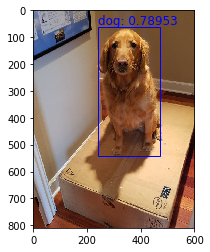

In [313]:
from PIL import Image, ImageDraw
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import time
import json

# Read labelmap
object_label_map = []
with open('coco_labelmap.txt', 'r') as f:
    for line in f:
        object_label_map.append(line.strip())

# Load image and resize it for inference.
pil_img = Image.open('dog.jpg')
height, width, _ = np.array(pil_img).shape
#Preprocess for base model
image = pil_img.resize((128,128)).convert('RGB')
image = np.array(image)
im =  image.reshape(128,128, 3)

#Inference by base model
result = predictor.predict({"input":im})

# Extract results of which score is larger than 0.5
scores = result['predictions'][0]['scores']
good_scores = [score for score in scores if score > 0.5]

# Parse result data
rect = []
label = []
score = []
for i in range(len(good_scores)):
    # Extract box data and generate rectangle objects to be draw on image later
    box = result['predictions'][0]['boxes'][i]
    y_min = box[0]*height
    x_min = box[1]*width
    y_max = box[2]*height
    x_max = box[3]*width
    im_width = x_max - x_min
    im_height = y_max - y_min 
    rect.append(patches.Rectangle((x_min,y_min),im_width,im_height,linewidth=1,edgecolor='b',facecolor='none'))
    
    # Store the label name
    label_id = result['predictions'][0]['classes'][i]
    label.append(object_label_map[int(label_id)])
    
    # Store score
    score.append(good_scores[i])

# Display the image with bounding boxes, labels and scores.
fig,ax = plt.subplots(1)
ax.imshow(np.array(pil_img))
for index in range(len(rect)):
    ax.add_patch(rect[index])
    caption = label[index] + ": " + str(score[index])
    plt.text(x_min,y_min-10,caption,fontsize='12', color = 'b')
plt.show()

Border terrier: 0.601103


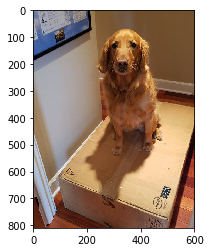

In [303]:
# get the endpoint name from the default predictor
endpoint = predictor.endpoint
im =  image.reshape(-1, 128,128,3)
# get a predictor for 'model2'
model2_predictor = Predictor(endpoint, model_name='model2')

class_id=np.argmax(model2_predictor.predict(im)['predictions'][0]['probabilities'])
probability = model2_predictor.predict(im)['predictions'][0]['probabilities'][class_id]

cls_label_map = []
with open('imagenet_labelmap.txt', 'r') as f:
    for line in f:
        cls_label_map.append(line.strip())
print(cls_label_map[class_id] + ": " + str(probability))
fig,ax = plt.subplots(1)
ax.imshow(np.array(pil_img))
plt.show()